In [232]:
import numpy as np

def convert_w2c(matrix_world_to_camera, frame, point):

    point_4d = np.resize(point, 4)
    point_4d[3] = 1
    co_local = matrix_world_to_camera.dot(point_4d)
    z = -co_local[2]

    if z == 0.0:
            return np.array([0.5, 0.5, 0.0])
    else:
        for i in range(3):
            frame[i] =  -(frame[i] / (frame[i][2]/z))

    min_x, max_x = frame[2][0], frame[1][0]
    min_y, max_y = frame[1][1], frame[0][1]

    x = (co_local[0] - min_x) / (max_x - min_x)
    y = (co_local[1] - min_y) / (max_y - min_y)

    return np.array([x,y,z])

In [452]:
import pickle
import imageio
import matplotlib.pyplot as plt
import numpy as np
import cv2

ANNOTATIONS_PATH = "../../image2sdf/input_images_validation/annotations.pkl"
MATRIX_PATH = "../../image2sdf/input_images_validation/matrix_w2c.pkl"
IMAGES_PATH = "../../image2sdf/input_images_validation/images/"
annotations_file = open(ANNOTATIONS_PATH, "rb")
matrix_file = open(MATRIX_PATH, "rb")
annotations = pickle.load(annotations_file)
matrix_world_to_camera = pickle.load(matrix_file)

In [509]:
scene_id = list(annotations.keys())[0]
image_id = 2
image_pth = IMAGES_PATH + scene_id + '/' + str(image_id) + '.png'
im = imageio.imread(image_pth)
loc_2d = annotations[scene_id][image_id]['2d'].copy()
loc_3d = annotations[scene_id][image_id]['3d'].copy()
frame = annotations[scene_id][image_id]['frame']


num_interp = 7
loc_mid_3d = np.empty([num_interp,4,3])
for i in range(num_interp):
    loc_mid_3d[i,0,:] = loc_3d[0,:] * (1-i/(num_interp-1)) + loc_3d[4,:] * i/(num_interp-1)
    loc_mid_3d[i,1,:] = loc_3d[1,:] * (1-i/(num_interp-1)) + loc_3d[5,:] * i/(num_interp-1)
    loc_mid_3d[i,2,:] = loc_3d[2,:] * (1-i/(num_interp-1)) + loc_3d[6,:] * i/(num_interp-1)
    loc_mid_3d[i,3,:] = loc_3d[3,:] * (1-i/(num_interp-1)) + loc_3d[7,:] * i/(num_interp-1)

loc_mid_2d = np.empty_like(loc_mid_3d)
for i in range(num_interp):
    for j in range(4):
      loc_mid_2d[i,j,:] = convert_w2c(matrix_world_to_camera, frame, loc_mid_3d[i,j,:]) 


###### y coordinate is inverted #####
loc_2d[:,1] = 1- loc_2d[:,1]
loc_mid_2d[:,:,1] = 1- loc_mid_2d[:,:,1]

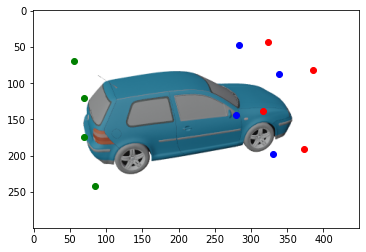

In [510]:
interp = 1

plt.figure()
plt.imshow(im)
plt.scatter(x = loc_2d[:4,0] * 450, y = loc_2d[:4,1] * 300, c = 'r')
plt.scatter(x = loc_2d[4:,0] * 450, y = loc_2d[4:,1] * 300, c = 'g')
plt.scatter(x = loc_mid_2d[interp,:,0] * 450, y = loc_mid_2d[interp,:,1] * 300, c = 'b')

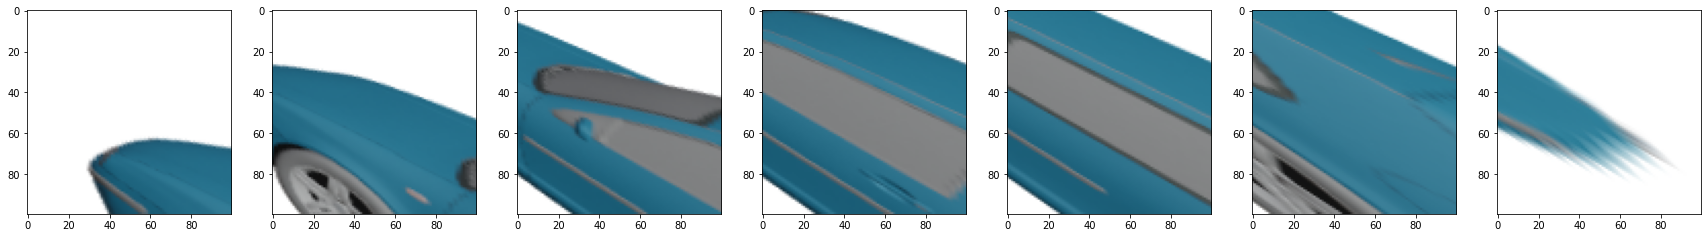

In [512]:
height, width = 100, 100
fig, axs = plt.subplots(1,num_interp, figsize=(30,10))
for i in range(num_interp):
    src = np.array([loc_mid_2d[i,0,:2],loc_mid_2d[i,1,:2],loc_mid_2d[i,2,:2],loc_mid_2d[i,3,:2]])
    src[:,0] = src[:,0] * 450
    src[:,1] = src[:,1] * 300
    dst = np.array([[0,height],[width,height],[width,0],[0,0]])
    h, mask = cv2.findHomography(src, dst)

    axs[i].imshow(cv2.warpPerspective(im, h, (width,height)))
